In [1]:
import numpy as np
from matplotlib import pyplot as plt
import requests


# Download file
r = requests.get('https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt')
with open("Summary_table.txt", 'wb') as f:
    f.write(r.content)

# Read content
data = np.loadtxt("Summary_table.txt", dtype=str,unpack='True')

# Read headers
with open("Summary_table.txt",'r') as f:
    names = np.array([n.strip().replace(" ","_") for n in f.readlines()[1].replace("#","").replace("\n","").lstrip().split('    ') if n.strip()!=''])
    
print(data.shape)
print(data[:,0])
print(names)


(15, 8790)
['GRB250704B' 'None' '8:16:31.045' '300.8716' '12.0233' '-999' '-999'
 '-999' '-999' '-999' '-999' '0.6610' '-999' 'False' '60860.34480376']
['GRB_name' 'GRB_name_Fermi' 'T0' 'ra' 'decl' 'pos_error' 'T90'
 'T90_error' 'T90_start' 'fluence' 'fluence_error' 'redshift' "'T100'"
 'GBM_located' 'mjd_(T0)']


C:\Users\nicco\AppData\Local\Temp\ipykernel_2580\1050767185.py:12: UserWarning: Input line 1 contained no data and will not be counted towards `max_rows=50000`.  This differs from the behaviour in NumPy <=1.22 which counted lines rather than rows.  If desired, the previous behaviour can be achieved by using `itertools.islice`.
Please see the 1.23 release notes for an example on how to do this.  If you wish to ignore this warning, use `warnings.filterwarnings`.  This warning is expected to be removed in the future and is given only once per `loadtxt` call.
  data = np.loadtxt("Summary_table.txt", dtype=str,unpack='True')


In [2]:
# Convert to float for numerical operations
d_data=dict(zip(names,data))
for i in ['ra', 'decl','T90',"T90_error", "fluence", "fluence_error", "redshift"]:
    d_data[i] = np.array(d_data[i],dtype='float')


#Control for None values
if any in d_data == None:
    print("There are None values in the data")
else:
    print("There are no None values in the data")

#Substitute all -999 values with np.nan
# Convert to float for numerical operations
for i in ['ra', 'decl','T90',"T90_error", "fluence", "fluence_error", "redshift"]:
    d_data[i] = np.where(d_data[i] == -999, np.nan, d_data[i]) 

There are no None values in the data


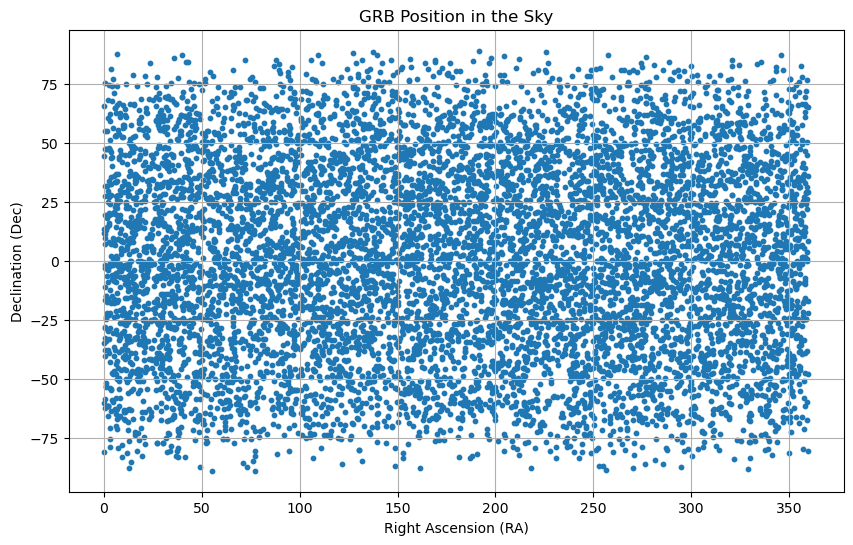

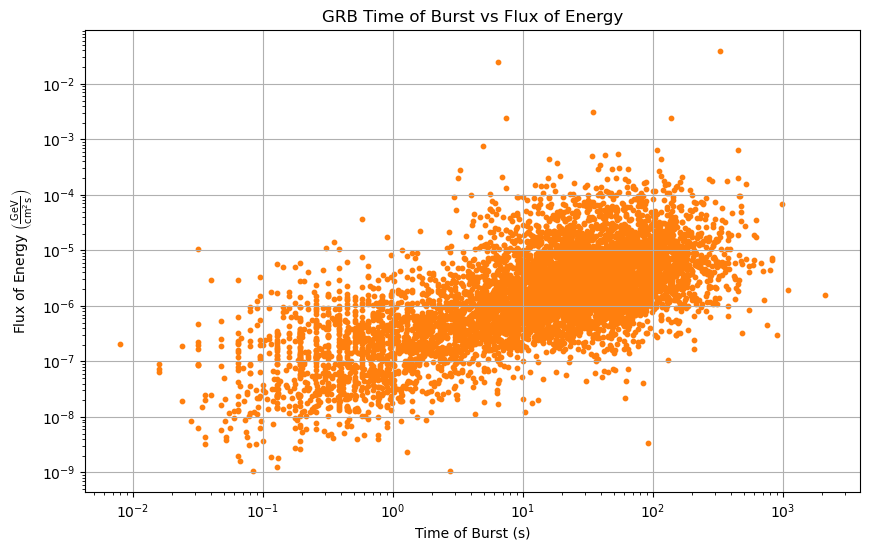

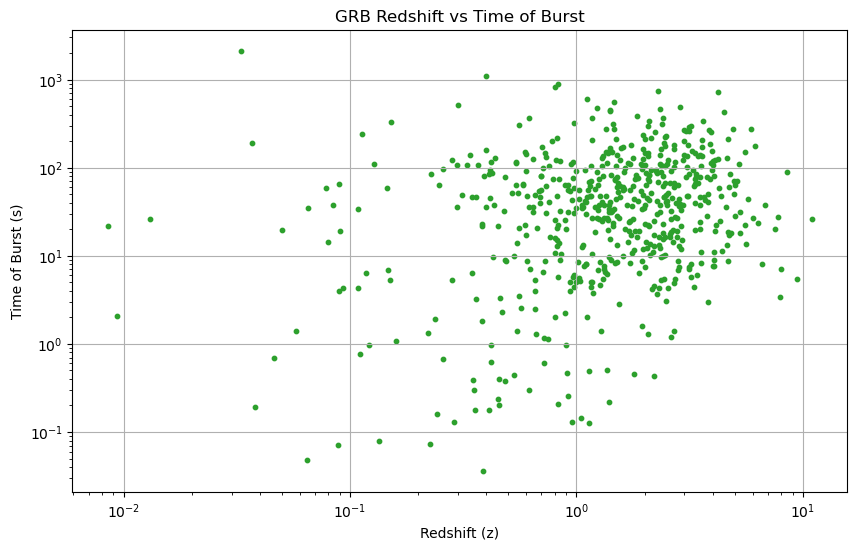

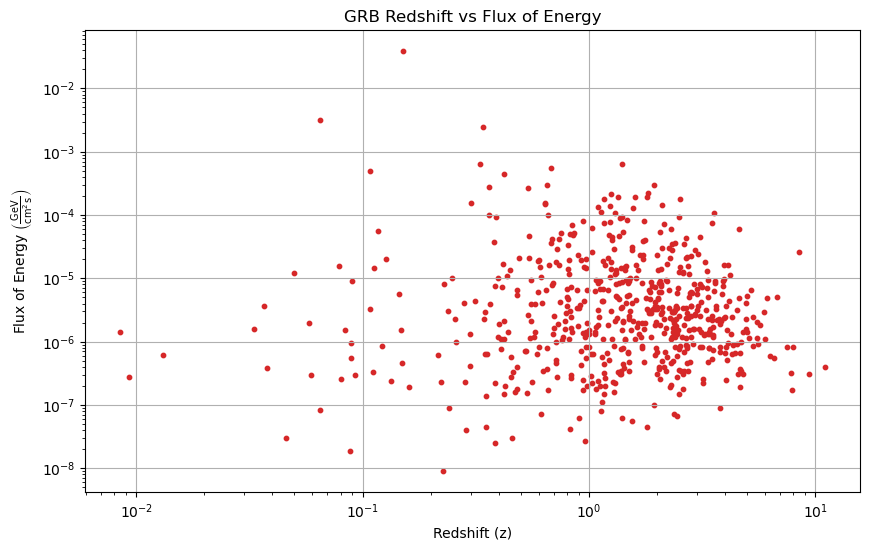

In [3]:
#Starting plotting the data
#Create a scatter plot for position in the sky
fig1, ax1 = plt.subplots(figsize=(10, 6))
ax1.scatter(d_data['ra'], d_data['decl'], s=10, c='tab:blue')
ax1.set_xlabel('Right Ascension (RA)')
ax1.set_ylabel('Declination (Dec)')
ax1.set_title('GRB Position in the Sky')
ax1.grid()

#Scatter plot for time of burst vs flux of energy 
fig2, ax2 = plt.subplots(figsize=(10, 6))
ax2.scatter(d_data['T90'], d_data['fluence'], s=10, c='tab:orange')
ax2.set_xlabel('Time of Burst (s)')
ax2.set_ylabel(r'Flux of Energy $\left(\frac{\mathrm{GeV}}{\mathrm{cm}^2\,\mathrm{s}}\right)$')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_title('GRB Time of Burst vs Flux of Energy')
ax2.grid()

#Scatter plot for time of burst vs redshift
fig3, ax3 = plt.subplots(figsize=(10, 6))
ax3.scatter(d_data['redshift'], d_data['T90'], s=10, c='tab:green')
ax3.set_ylabel('Time of Burst (s)')
ax3.set_xlabel('Redshift (z)')
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_title('GRB Redshift vs Time of Burst')
ax3.grid()

#Scatter plot for flux of energy vs redshift
fig4, ax4 = plt.subplots(figsize=(10, 6))   
ax4.scatter(d_data['redshift'], d_data['fluence'], s=10, c='tab:red')
ax4.set_ylabel(r'Flux of Energy $\left(\frac{\mathrm{GeV}}{\mathrm{cm}^2\,\mathrm{s}}\right)$')
ax4.set_xlabel('Redshift (z)')
ax4.set_xscale('log')
ax4.set_yscale('log')
ax4.set_title('GRB Redshift vs Flux of Energy')
ax4.grid()


(8790, 2)
Removing any sample with NaN rows
Cluserization ready to start
(7555, 2)


Text(0.5, 1.0, 'K-Means Clustering')

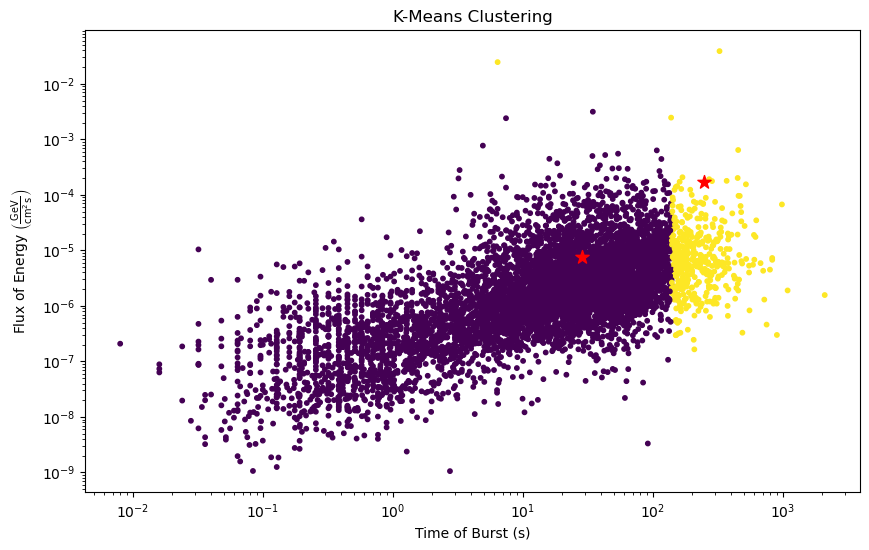

In [4]:
#CLUSTERING USING K-MEANS WITH 2 CLUSTERS
from sklearn.cluster import KMeans
from sklearn import preprocessing

#For clustering selected the time of burst and flux of energy
X = d_data['T90']
X = np.vstack([X, d_data['fluence']]).T
print(X.shape)

#First remove every sample with Nan values
print("Removing any sample with NaN rows")
X = X[~np.isnan(X).any(axis=1)]
if np.isnan(X).any():
    print("Cluserization failed due to unremoved NaN values")
else:
    print("Cluserization ready to start")

print(X.shape)

#Normalize the data
scaler = preprocessing.StandardScaler()
X_scaled = scaler.fit_transform(X)

clf = KMeans(n_clusters=2, random_state=42)
clf.fit(X_scaled)
centers = scaler.inverse_transform(clf.cluster_centers_)
labels = clf.labels_

#First plot without normalization
fig5, ax5 = plt.subplots(figsize=(10, 6))
ax5.scatter(X[:,0], X[:,1], c=labels, s=10, cmap='viridis')
ax5.scatter(centers[:,0], centers[:,1], c='red', s=100, marker='*', label='Centroids')
ax5.set_xlabel('Time of Burst (s)')
ax5.set_ylabel(r'Flux of Energy $\left(\frac{\mathrm{GeV}}{\mathrm{cm}^2\,\mathrm{s}}\right)$')
ax5.set_xscale('log')
ax5.set_yscale('log')
ax5.set_title('K-Means Clustering')


Text(0.5, 1.0, 'Mean-Shift Clustering')

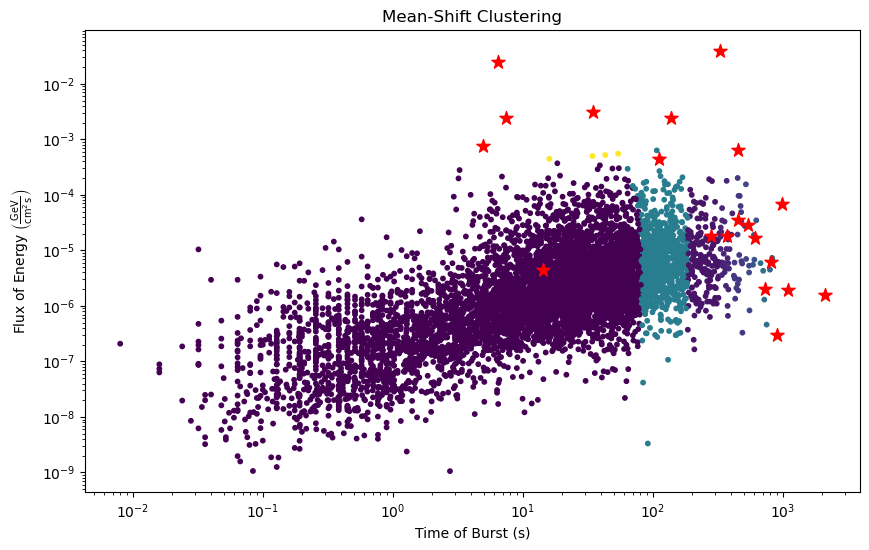

In [5]:
#CLUSTERING WITH MEAN-SHIFT 
from sklearn.cluster import MeanShift, estimate_bandwidth

bw = estimate_bandwidth(X_scaled)
ms = MeanShift(bandwidth=bw, bin_seeding=True)
ms.fit(X_scaled)
centers_ms = scaler.inverse_transform(ms.cluster_centers_)
labels_ms = ms.labels_

fig6, ax6 = plt.subplots(figsize=(10, 6))
ax6.scatter(X[:,0], X[:,1], c=labels_ms, s=10, cmap='viridis')
ax6.scatter(centers_ms[:,0], centers_ms[:,1], c='red', s=100, marker='*', label='Centroids')
ax6.set_xlabel('Time of Burst (s)')
ax6.set_ylabel(r'Flux of Energy $\left(\frac{\mathrm{GeV}}{\mathrm{cm}^2\,\mathrm{s}}\right)$')
ax6.set_xscale('log')
ax6.set_yscale('log')
ax6.set_title('Mean-Shift Clustering')

Text(0.5, 0, 'T90 (s)')

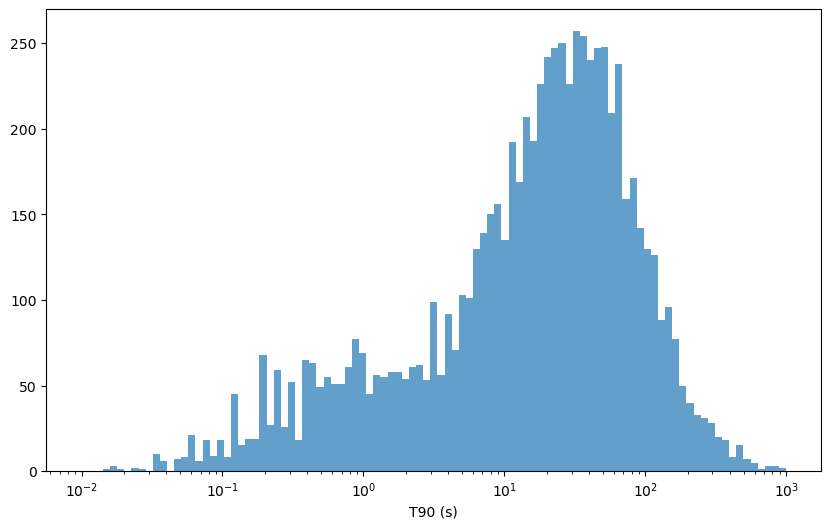

In [6]:
#NOTHING WORKED, TRYING 1D PROBLEM WITH T90
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity

fig7, ax7 = plt.subplots(figsize=(10, 6))
X = d_data['T90']
X= X[~np.isnan(d_data['T90'])] # Remove NaN values
ax7.hist(X, bins=np.logspace(-2, 3, 100), color='tab:blue', alpha=0.7, label='Histogram of T90')
ax7.set_xscale('log')
ax7.set_xlabel('T90 (s)')


In [7]:
logX =np.log10(X)  # Transform to log scale for KDE
logX = logX[~np.isnan(logX)]  # Remove NaN values after transformation
bwrange = np.linspace(0.01,1.0, 30) 
K = 10 # Do 10-fold cross validation
grid = GridSearchCV(KernelDensity(), {'bandwidth': bwrange}, cv= K) # Try each bandwidth with K-folds
grid.fit(logX[:,np.newaxis])  
h_opt = grid.best_params_['bandwidth']
print("Optimal bandwidth: ", h_opt)


Optimal bandwidth:  0.11241379310344828


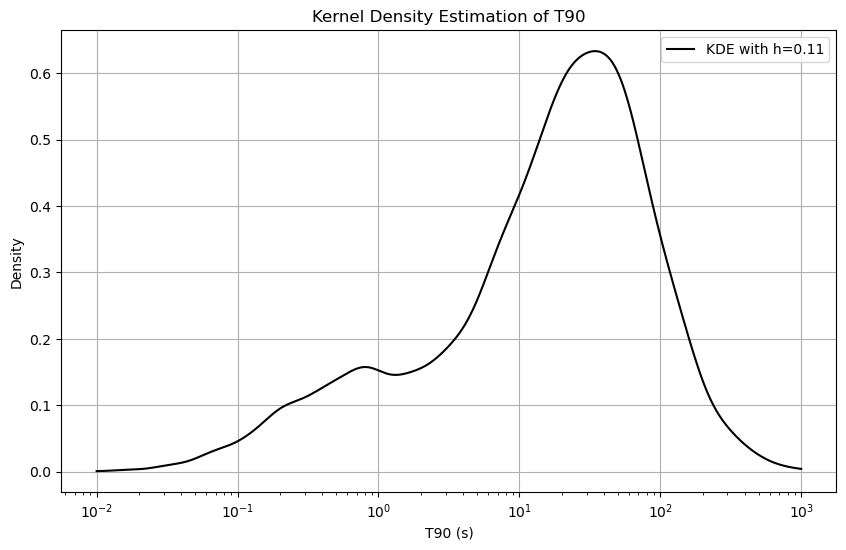

In [8]:
Xgrid = np.logspace(-2, 3, 1000)  # Create a grid for evaluation
kde =KernelDensity(kernel='gaussian', bandwidth=h_opt)
kde.fit(logX[:, np.newaxis])  # Fit the KDE model
dens = np.exp(kde.score_samples(np.log10(Xgrid[:, np.newaxis])))  # Evaluate the density on the grid

fig8, ax8 = plt.subplots(figsize=(10, 6))
ax8.plot(Xgrid, dens, color='k', label=f'KDE with h={h_opt:.2f}')
ax8.set_xscale('log')
ax8.set_xlabel('T90 (s)')
ax8.set_ylabel('Density')
ax8.set_title('Kernel Density Estimation of T90')
ax8.legend()
ax8.grid()

Cluster centers: [32.61215062  0.87707901]
Contour of clusters: 5.331000000000001


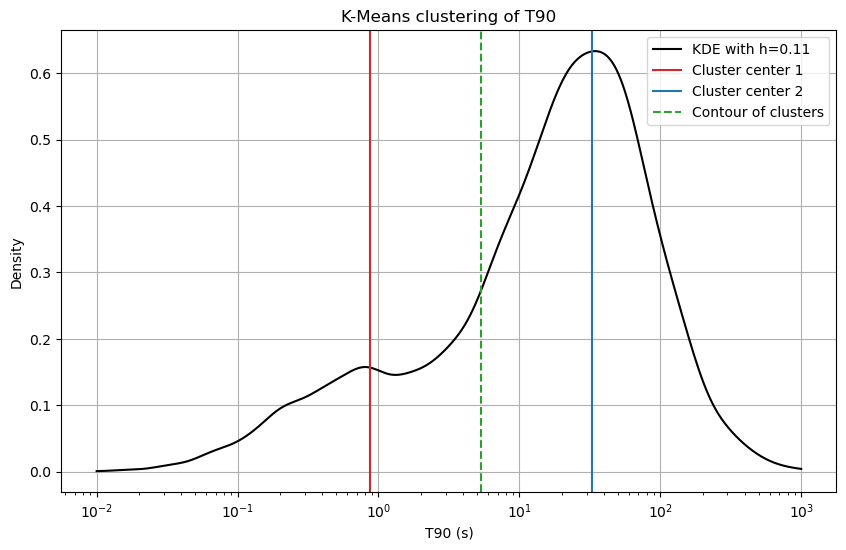

In [9]:
clf = KMeans(n_clusters=2, random_state=42)
clf.fit(logX[:, np.newaxis])
centers = clf.cluster_centers_
centers = np.squeeze(10**centers)  # Convert back to original scale and 1D array
print("Cluster centers:", centers)
labels = clf.predict(logX[:, np.newaxis])

if centers[0] > centers[1]:
    centers = centers[::-1]  # Ensure the first center is always the smaller one
    labels = 1 - labels  # Swap labels accordingly

contour = np.mean([10**np.max(logX[labels == 0]), 10**np.min(logX[labels == 1])])
print("Contour of clusters:", contour)

fig9, ax9 = plt.subplots(figsize=(10, 6))
ax9.plot(Xgrid, dens, color='k', label=f'KDE with h={h_opt:.2f}')
ax9.axvline(centers[0], color='tab:red', linestyle='-', label='Cluster center 1')
ax9.axvline(centers[1], color='tab:blue', linestyle='-', label='Cluster center 2')
ax9.axvline(x = contour, color='tab:green', linestyle='--', label='Contour of clusters')
ax9.set_xscale('log')
ax9.set_xlabel('T90 (s)')
ax9.set_ylabel('Density')
ax9.set_title('K-Means clustering of T90')
ax9.legend()
ax9.grid()


Gaussian Mixture centers: [ 0.93834456 30.49343774]


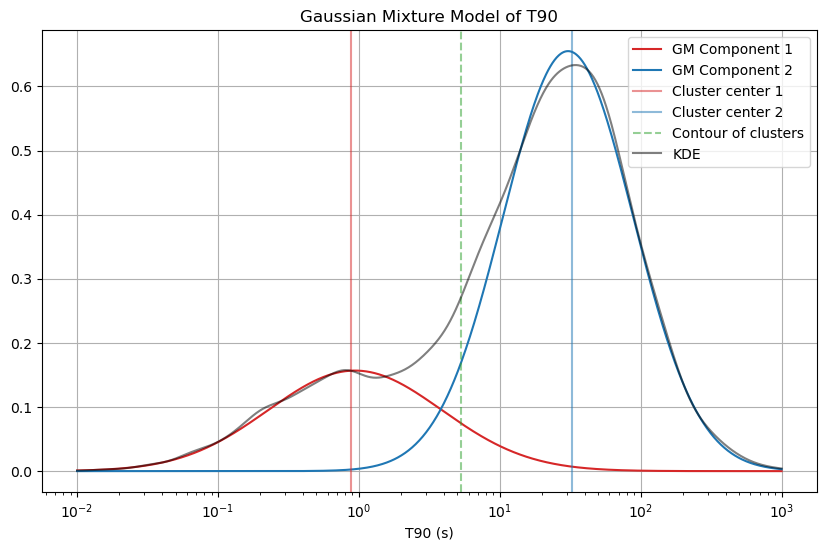

In [10]:
#FIT MULTIMODAL GAUSSIAN MODEL WITH GAUSSIANMIXTURE

from sklearn.mixture import GaussianMixture
from scipy.stats import norm

gm = GaussianMixture(n_components=2, random_state=42)
gm.fit(logX[:, np.newaxis])
gm_centers = np.squeeze(gm.means_)  # Convert back to original scale and 1D array
gm_cov =np.squeeze(gm.covariances_)
gm_weights = np.squeeze(gm.weights_)
gm_labels = gm.predict(logX[:, np.newaxis])

if gm_centers[0] > gm_centers[1]:
    gm_centers = gm_centers[::-1]  # Ensure the first center is always the smaller one, and swap everything accordingly
    gm_cov = gm_cov[::-1] 
    gm_weights = gm_weights[::-1]  
    gm_labels = 1 - gm_labels 
     
print("Gaussian Mixture centers:", 10**gm_centers)

fig10, ax10 = plt.subplots(figsize=(10, 6))
ax10.plot(Xgrid, gm_weights[0]*norm.pdf(np.log10(Xgrid), gm_centers[0], np.sqrt(gm_cov[0])), color='tab:red', label='GM Component 1')
ax10.plot(Xgrid, gm_weights[1]*norm.pdf(np.log10(Xgrid), gm_centers[1], np.sqrt(gm_cov[1])), color='tab:blue', label='GM Component 2')
ax10.axvline(centers[0], color='tab:red', linestyle='-', alpha = 0.5, label='Cluster center 1')
ax10.axvline(centers[1], color='tab:blue', linestyle='-', alpha = 0.5, label='Cluster center 2')
ax10.axvline(x = contour, color='tab:green', linestyle='--', alpha = 0.5, label='Contour of clusters')
ax10.plot(Xgrid, dens, color='k', label='KDE', alpha=0.5)
ax10.set_xscale('log')
ax10.set_xlabel('T90 (s)')
ax10.set_title('Gaussian Mixture Model of T90')
ax10.legend()
ax10.grid()

In [11]:
#Establish the most likely kind of GRB
print("Ratio of prior probabilities of cluster 1 over cluster 2:", gm_weights[0]/gm_weights[1])
print("Ratio of responsibilities mode1/mode2 (how much a mode contributes to our data):",np.sum(gm.predict_proba(logX[:, np.newaxis])[:,1])/np.sum(gm.predict_proba(logX[:, np.newaxis])[:,0]))


Ratio of prior probabilities of cluster 1 over cluster 2: 0.31998386176821064
Ratio of responsibilities mode1/mode2 (how much a mode contributes to our data): 0.31847736538680554


Text(0.5, 1.0, 'Redshift Distribution of GRBs')

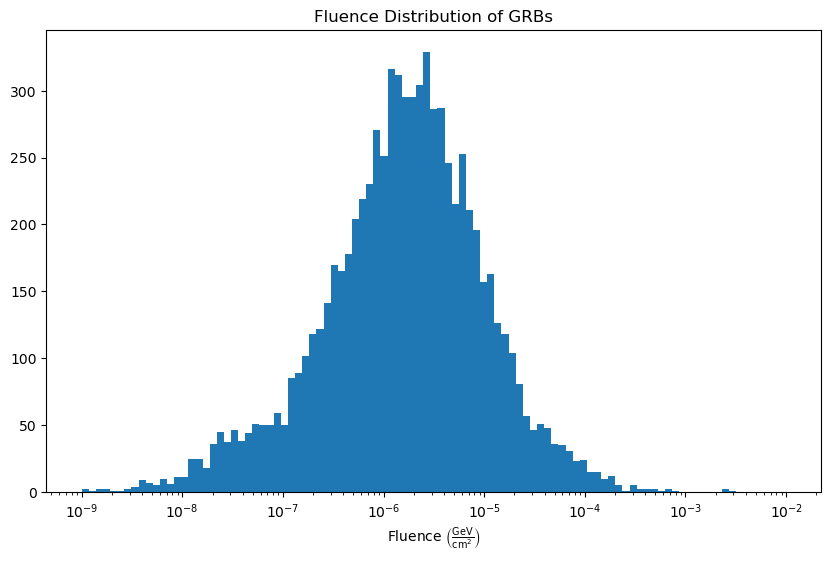

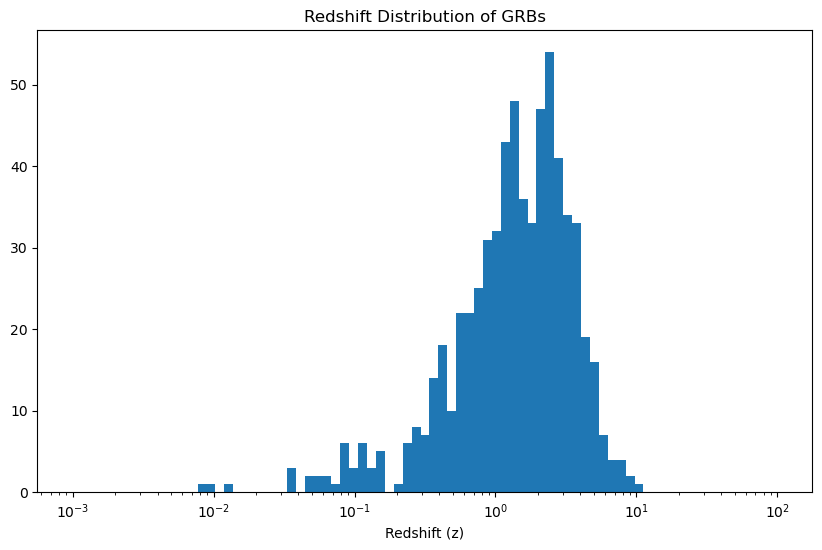

In [12]:
#We can try visualizing also energy flux distribution and redshift
fig11, ax11 = plt.subplots(figsize=(10, 6))
ax11.hist(d_data['fluence'],bins = np.logspace(-9,-2,100), color='tab:blue', label='Histogram of Fluence')
ax11.set_xscale('log')
ax11.set_xlabel(r'Fluence $\left(\frac{\mathrm{GeV}}{\mathrm{cm}^2}\right)$')
ax11.set_title('Fluence Distribution of GRBs')

fig12, ax12 = plt.subplots(figsize=(10, 6))
ax12.hist(d_data['redshift'], bins=np.logspace(-3,2,80), color='tab:blue', label='Histogram of Redshift')
ax12.set_xscale('log')
ax12.set_xlabel('Redshift (z)')
ax12.set_title('Redshift Distribution of GRBs')

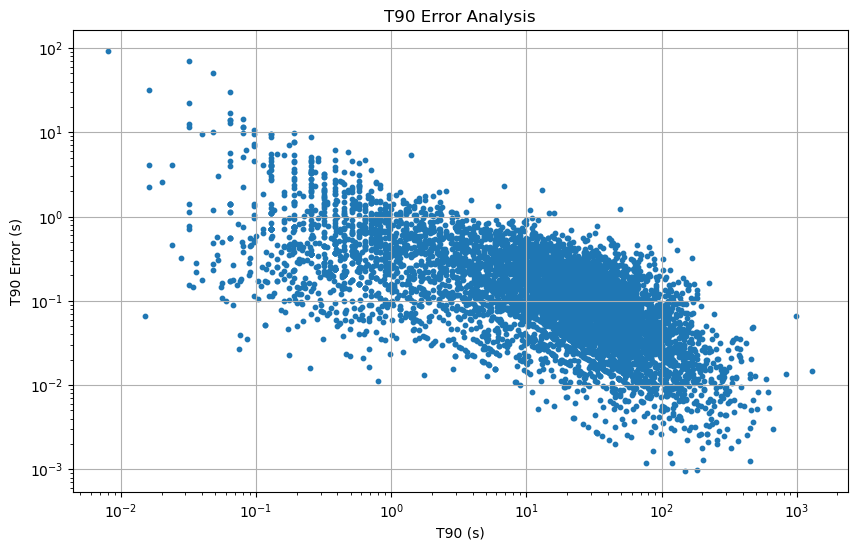

In [13]:
#Analysis of errors on T90
fig13, ax13 = plt.subplots(figsize=(10, 6))
ax13.scatter(d_data['T90'], d_data['T90_error']/d_data['T90'], s=10, c='tab:blue')
ax13.set_xlabel('T90 (s)')
ax13.set_ylabel('T90 Error (s)')
ax13.set_xscale('log')
ax13.set_yscale('log')
ax13.set_title('T90 Error Analysis')
ax13.grid()

#COULD BE DONE WITH MCMC DOUBLE GAUSSIAN FITTING